# Statistical Machine Learning Exercise Sheet 8
- Laura Haege
- Philipp Noel von Bachmann, Matrikelnummer: 4116220

In [1]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve
import itertools
from tqdm import tqdm

In [2]:
data = np.load("DataFeatSel.npy", allow_pickle=True).item()
X_train = data["Xtrain"]
Y_train = data["Ytrain"]
X_test = data["Xtest"]
Y_test = data["Ytest"]

## Exercise 14

In [3]:
def train(X, y):
    w = cho_solve(cho_factor(X.T @ X), X.T @ y)
    return w, X @ w

In [4]:
def Loss(y_pred, y):
    return 0.5*np.sum(np.abs(y - np.sign(y_pred)))/len(y)

In [5]:
def CrossValidation(X, Y, k=5, use_tqdm=True):
    min_loss = np.inf
    min_mask = []

    X_split = np.array(np.array_split(X, k))
    Y_split = np.array(np.array_split(Y, k))

    masks = list(itertools.product([True, False], repeat=X.shape[1]))[:-1]
    if use_tqdm:
        masks = tqdm(masks)
    for m in masks:
        # compute k-fold cross validation
        validation_loss = []
        for i in range(k):
            x_train = np.concatenate(np.delete(X_split, i, axis=0))[:, m] # add mask
            y_train = np.concatenate(np.delete(Y_split, i, axis=0))
            x_val = X_split[i][:, m] # add mask
            y_val = Y_split[i]
            w, x_pred = train(x_train, y_train)
            validation_loss.append(Loss(x_val @ w, y_val))
        # average over all losses and store
        validation_loss = np.mean(validation_loss)

        # check if smaller
        if validation_loss < min_loss:
            min_loss = validation_loss
            min_mask = [m]
        elif validation_loss == min_loss:
            min_mask.append(m)

    # find the ones with the least amount of features
    feature_size = list(map(lambda x: np.sum(x), min_mask))
    min_index = np.where(feature_size == np.min(feature_size))[0]
    return np.array(min_mask)[min_index], min_loss

In [6]:
mask, min_loss =  CrossValidation(X_train, Y_train)

100%|██████████| 32767/32767 [00:20<00:00, 1637.99it/s]


In [7]:
# train on full set
weights = []
for m in mask:
    print(f"One min feature mask is/subset: {m}")
    w, x_pred = train(X_train[:, m], Y_train)
    weights.append(w)
    print(f"The associated training loss is {Loss(x_pred, Y_train)}")

One min feature mask is/subset: [False False False  True False False False False  True  True False False
 False False False]
The associated training loss is 0.2
One min feature mask is/subset: [False False False  True False False False False False  True  True False
 False False False]
The associated training loss is 0.2


In [8]:
# testing on new data
for m, w in zip(mask, weights):
    print(f"One min feature mask/subset is: {m}")
    print(f"The associated test loss is {Loss(X_test[:, m] @ w, Y_test)}")

One min feature mask/subset is: [False False False  True False False False False  True  True False False
 False False False]
The associated test loss is 0.497
One min feature mask/subset is: [False False False  True False False False False False  True  True False
 False False False]
The associated test loss is 0.502


The error on the test set significantly is higher than on the training set. This can have several reasons:
- Overfitting to the training set (unlikely with small amout of features but for example more features in truth relate to the classification than the training set suggests)
- The training set and the test set come from different distributions and just don't belong together.
- The labels are independent of the features, and we were just "lucky" that these features explained the training set well.



The difference probably has to do with the classifier, because we could get a small error just with a subset of features. However if the labels are independent of features, then both the classifier and feature selection are not the porblem but rather the prediction task.

We would probably tell the biologists that they should look back at their dataset and make sure the data was generated correctly and the model is reasonable to solve the task.

## Exercise 15

In [9]:
def Permutation_Test(X, y, alpha=0.05, n_samples=1000):
    t_pis = []
    # the baseline error is given as:
    _, T = CrossValidation(X, y, use_tqdm=False)
    print(f"The Cross Validation error of the Baseline is {T}\n")

    for i in tqdm(range(n_samples)):
        random_permutation = np.random.permutation(y.shape[0])
        y_perm = y[random_permutation]
        _, T_pi = CrossValidation(X, y_perm, use_tqdm=False)
        t_pis.append(T_pi)

    t_pis = np.array(t_pis)
    p = np.sum(t_pis <= T)/t_pis.shape[0]
    print(f"\nThe result of th permutation test is that X and Y are {'in' if p > alpha else ''}dependent.")
    print("The p value is: ", p)
    print(f"The mean cross validation error is: {np.mean(t_pis)}")
    return t_pis


We measure the cross validation error of the base classifier: 0.493. If Y is dependent on the X, this would mean that a permuted assignment of Y would lead to a worse error. Therefore we reject the test if more than $1 - \alpha$ percent of the permuted losses lie above 0.493.

In [10]:
X_new = X_test[:, :6]
result = Permutation_Test(X_new, Y_test)

The Cross Validation error of the Baseline is 0.493



100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


The result of th permutation test is that X and Y are independent.
The p value is:  0.986
The mean cross validation error is: 0.46929200000000004


The results of the test imply that indeed the labels are independent of the features. This implies for 14. that the features we learned we just randomly good for the training dataset, but captured no underlying structure of the actual data generating process.

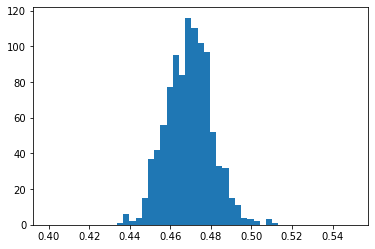

In [16]:
from matplotlib import pyplot as plt
bins = np.linspace(0.4, 0.55, 50)
plt.hist(result, bins=bins);